In [139]:
# Binance API information
API_KEY = ""
SECRET_KEY = ""


In [ ]:
import requests
import json
import pandas as pd
import datetime as dt
import backtrader as bt
from datetime import datetime
from matplotlib import pyplot as plt

In [190]:
import requests
import time

def fetch_binance_historical_data(symbol, interval, start_time, end_time):
    """
    Fetches historical k-line data from Binance API for a given symbol, interval, start time, and end time.
    
    :param symbol: str, trading pair symbol (e.g., 'BTCUSDT' for Bitcoin/USDT)
    :param interval: str, timeframe for the historical data (e.g., '1d' for daily)
    :param start_time: int, start timestamp in milliseconds
    :param end_time: int, end timestamp in milliseconds
    :return: list of dictionaries, historical k-line data
    """
    # Define API endpoint
    endpoint = 'https://api.binance.com/api/v3/klines'
    
    # Initialize empty list to store historical data
    historical_data = []
    
    # Loop until end time is reached
    while start_time < end_time:
        # Calculate remaining time until end time or maximum allowed timeframe (500 data points)

        if interval[-1] == 'h':
            interval_size = (int(interval[0]) * 60) - 1
        else:
            interval_size = int(interval[:-1])
        
        remaining_time = min(end_time - start_time, 500 * interval_size * 60 * 1000)
        
        # Define API parameters for current request
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_time,
            'endTime': start_time + remaining_time,
            'limit': 500,
        }
        
        # Send API request and parse response
        response = requests.get(endpoint, params=params)
        data = response.json()

        # display(len(data)) 
        
        # Append fetched data to historical_data list
        historical_data.extend(data)
        
        # Update start time for next request
        start_time += remaining_time + (int(interval[:-1]) * 60 * 1000)
        
        # Add delay to avoid hitting API rate limits (optional)
        time.sleep(1)
    
    return historical_data


In [218]:
# hist_data = fetch_binance_historical_data(symbol = 'AXSUSDT',
#                                           interval = '1h',
#                                           start_time = int(dt.datetime(2023,3,1).timestamp()*1000),
#                                           end_time = int(dt.datetime(2023,4,13).timestamp()*1000))

hist_data = fetch_binance_historical_data(symbol = 'AXSUSDT',
                                          interval = '1h',
                                          start_time = int(dt.datetime(2023,3,1).timestamp()*1000),
                                          end_time = int(dt.datetime(2023,5,6).timestamp()*1000))

In [219]:
len(hist_data)

1584

In [220]:
data = pd.DataFrame(hist_data)
#format columns name
data.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.datetime]
data=data.astype(float)
data.tail()

,datetime,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
2023-05-05 20:00:00,1.683288e+12,7.62,7.64,7.47,7.55,44559.89,1.683292e+12,336678.8271,1578.0,14863.18,112301.7937,0.0
2023-05-05 21:00:00,1.683292e+12,7.55,7.62,7.53,7.61,16389.72,1.683295e+12,124179.4459,484.0,9290.71,70441.7859,0.0
2023-05-05 22:00:00,1.683295e+12,7.62,7.69,7.61,7.68,36715.20,1.683299e+12,280721.0257,975.0,20826.63,159304.9533,0.0
2023-05-05 23:00:00,1.683299e+12,7.68,7.73,7.67,7.71,30138.36,1.683302e+12,232078.7388,757.0,20587.24,158573.0048,0.0
2023-05-06 00:00:00,1.683302e+12,7.72,7.81,7.71,7.77,70995.83,1.683306e+12,551780.6399,1755.0,44215.81,343750.4254,0.0


In [ ]:


from scipy.optimize import differential_evolution
from bayes_opt import BayesianOptimization

# Define objective function
# Define objective function for Bayesian optimization
def objective(fast_length, normal_length, slow_length):
    # Convert parameters to integer values
    fast_length = int(fast_length)
    slow_length = int(slow_length)
    normal_length = int(normal_length)
    # Define strategy
    class EMAStrategy(bt.Strategy):
        params = (
            ('starting_cash', 10000),
        )
    
        def __init__(self):
            self.fast_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=fast_length)
            self.normal_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=normal_length)
            self.slow_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=slow_length)
            self.stop_loss_pct = 0.02  # 2% stop loss threshold
    
        def next(self):
            if not self.position:
                if (self.fast_ema > self.normal_ema) and (self.normal_ema > self.slow_ema):
                    # Buy signal
                    self.buy(size=self.params.starting_cash / self.data.close[0])
    
            else:
                if (self.fast_ema < self.normal_ema) or (self.normal_ema < self.slow_ema):
                # or \
                        # self.data.close[0] < self.position.price * (1 - self.stop_loss_pct):
                    # Sell signal or stop loss triggered
                    self.sell(size=self.position.size)
    
    cerebro = bt.Cerebro()
    
    # Add data to cerebro
    cerebro.adddata(bt.feeds.PandasData(dataname=data))
    
    # Add strategy to cerebro
    cerebro.addstrategy(EMAStrategy)
    
    # Set starting capital
    cerebro.broker.setcash(10000)
    
    # Run backtest
    results = cerebro.run()
    profit = results[0].broker.getvalue() - 10000
    # print(params)
    # print(profit)
    
    return profit  # Objective is to maximize profit
# , so we negate it for minimization



# Define parameter bounds for Bayesian optimization
bounds = {
    'fast_length': (5, 10),
    'slow_length': (50, 99),
    'normal_length': (15, 50)
}

# Perform Bayesian optimization
opt = BayesianOptimization(objective, bounds)
opt.maximize(n_iter=100, init_points=50,acq='ei')
# opt.maximize(n_iter=100, init_points=50)

# Extract optimal parameters
optimal_params = opt.max['params']
optimal_fast_length = int(optimal_params['fast_length'])
optimal_slow_length = int(optimal_params['slow_length'])
optimal_normal_length = int(optimal_params['normal_length'])
optimal_profit = float(opt.max['target'])

# Print optimal parameters
print('Optimal Parameters:')
print('Fast Length: {}'.format(optimal_fast_length))
print('Slow Length: {}'.format(optimal_slow_length))
print('Normal Length: {}'.format(optimal_normal_length))
print("Optimal Profit:", optimal_profit)


|   iter    |  target   | fast_l... | normal... | slow_l... |
-------------------------------------------------------------


<ipython-input-199-aa9fa13deaeb>:67: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=100, init_points=50,acq='ei')


| 151       | -155.8    | 5.315     | 44.48     | 92.6      |
| 152       | -199.5    | 6.595     | 46.21     | 89.65     |
| 153       | -19.12    | 8.206     | 29.08     | 85.06     |
| 154       | 1.911e+03 | 5.435     | 25.02     | 65.13     |
| 155       | -27.09    | 8.167     | 37.99     | 91.56     |
| 156       | -10.97    | 6.138     | 17.25     | 81.29     |
| 157       | 1.718e+03 | 8.481     | 39.49     | 53.09     |
| 158       | 1.587e+03 | 6.544     | 32.61     | 55.67     |
| 159       | 2.119e+03 | 9.447     | 22.57     | 51.38     |
| 160       | -49.27    | 9.824     | 34.47     | 68.35     |
| 161       | -24.9     | 6.202     | 30.91     | 68.04     |
| 162       | -208.6    | 6.401     | 36.2      | 69.11     |
| 163       | 1.453e+03 | 6.931     | 18.33     | 80.22     |
| 164       | -58.3     | 9.746     | 31.12     | 81.0      |
| 165       | -54.46    | 8.746     | 44.72     | 71.5      |
| 166       | -15.39    | 5.482     | 35.95     | 64.44     |
| 167   

In [227]:
# Strategy for long trades
# Define objective function for Bayesian optimization
class OptimizationModel():
    def __init__(self,data):
        self.data = data
            
    def objective(self,fast_length, normal_length, slow_length):
        # Convert parameters to integer values
        fast_length = int(fast_length)
        slow_length = int(slow_length)
        normal_length = int(normal_length)
        # Define strategy
        class EMAStrategy(bt.Strategy):
            params = (
                ('starting_cash', 10000),
            )
        
            def __init__(self):
                self.fast_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=fast_length)
                self.normal_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=normal_length)
                self.slow_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=slow_length)
                self.stop_loss_pct = 0.02  # 2% stop loss threshold
        
            def next(self):
                if not self.position:
                    if (self.fast_ema > self.normal_ema) and (self.normal_ema > self.slow_ema):
                        # Buy signal
                        self.buy(size=self.params.starting_cash / self.data.close[0])
        
                else:
                    if (self.fast_ema < self.normal_ema) or (self.normal_ema < self.slow_ema):
                    # or \
                            # self.data.close[0] < self.position.price * (1 - self.stop_loss_pct):
                        # Sell signal or stop loss triggered
                        self.sell(size=self.position.size)
        
        cerebro = bt.Cerebro()
        
        # Add data to cerebro
        cerebro.adddata(bt.feeds.PandasData(dataname=self.data))
        
        # Add strategy to cerebro
        cerebro.addstrategy(EMAStrategy)
        
        # Set starting capital
        cerebro.broker.setcash(10000)
        
        # Run backtest
        results = cerebro.run()
        profit = results[0].broker.getvalue() - 10000

        # print(params)
        # print(profit)
        
        return profit  # Objective is to maximize profit

In [232]:
def optimize_ema_strategy(pairs, start_date, end_date, interval):
    """
    Fetches OHLCV data for each pair, optimizes an EMA_strategy, and returns data, optimal ema value, and profit.
    """
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    # Step 1: Fetch OHLCV data for each pair
    data_dict = {}
    for pair in pairs:
        # Use the exchange API to fetch OHLCV data for each pair
        # and store it in a Pandas DataFrame


        hist_data = fetch_binance_historical_data(symbol = pair,
                                          interval = interval,
                                          start_time = int(dt.datetime(int(start_date.year),int(start_date.month),int(start_date.day)).timestamp()*1000),
                                          end_time = int(dt.datetime(int(end_date.year),int(end_date.month),int(end_date.day)).timestamp()*1000))
        data = pd.DataFrame(hist_data)
        #format columns name
        data.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
        data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.datetime]
        data=data.astype(float)
        data_dict[pair] = data

    
    # Step 2: Optimize the EMA_strategy for each pair
    optimal_ema_values = {}
    profits = {}
    for pair, data in data_dict.items():   
        # Define parameter bounds for Bayesian optimization
        bounds = {
            'fast_length': (5, 15),
            'slow_length': (40, 99),
            'normal_length': (12, 50)
        }

        # Perform Bayesian optimization
        model = OptimizationModel(data)
        opt = BayesianOptimization(model.objective, bounds)
        opt.maximize(n_iter=300, init_points=50,acq='ei')

        # Extract optimal parameters
        optimal_params = opt.max['params']
        optimal_fast_length = int(optimal_params['fast_length'])
        optimal_slow_length = int(optimal_params['slow_length'])
        optimal_normal_length = int(optimal_params['normal_length'])
        optimal_profit = float(opt.max['target'])

        # Print optimal parameters
        print('Optimal Parameters:')
        print('Fast Length: {}'.format(optimal_fast_length))
        print('Slow Length: {}'.format(optimal_slow_length))
        print('Normal Length: {}'.format(optimal_normal_length))
        print("Optimal Profit:", optimal_profit)

        optimal_ema_dict = {'Fast Length':optimal_fast_length,
                            'Slow Length':optimal_slow_length,
                            'Normal Length':optimal_normal_length
        }

        optimal_ema_values[pair] = optimal_ema_dict
        profits[pair] = optimal_profit
    # Step 3: Return the data, optimal ema values, and profits for each pair
    return data_dict, optimal_ema_values, profits


In [233]:
pairs = ['BTCUSDT','SOLUSDT','1INCHUSDT','AXSUSDT','ICPUSDT','NEARUSDT','IDEXUSDT','KP3RUSDT','DGBUSDT']
start_date = '2023-03-01'
end_date = '2023-05-06'
interval = '1h'

data_dict, optimal_ema_values, profits = optimize_ema_strategy(pairs, start_date, end_date, interval)

|   iter    |  target   | fast_l... | normal... | slow_l... |
-------------------------------------------------------------


<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 841.6     | 14.89     | 32.77     | 79.19     |
| 2         | 799.7     | 8.552     | 35.14     | 66.84     |
| 3         | 1.507e+03 | 14.69     | 49.03     | 96.15     |
| 4         | 1.722e+03 | 10.04     | 13.81     | 88.6      |
| 5         | 706.7     | 9.876     | 33.62     | 82.15     |
| 6         | 647.9     | 6.1       | 39.25     | 89.89     |
| 7         | 1.49e+03  | 14.82     | 43.84     | 57.59     |
| 8         | 549.4     | 6.927     | 37.17     | 74.72     |
| 9         | 1.776e+03 | 13.19     | 47.53     | 78.88     |
| 10        | 1.436e+03 | 13.14     | 42.86     | 65.34     |
| 11        | 1.87e+03  | 9.779     | 14.42     | 81.66     |
| 12        | 1.051e+03 | 11.2      | 38.06     | 54.29     |
| 13        | -51.08    | 14.37     | 45.57     | 44.54     |
| 14        | 1.31e+03  | 14.1      | 27.1      | 59.45     |
| 15        | 782.6     | 9.047     | 40.94     | 87.94     |
| 16        | 1.35e+03  | 13.87     | 43.81     | 53.27     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 1.823e+03 | 6.84      | 30.53     | 41.46     |
| 2         | 1.563e+03 | 11.53     | 17.48     | 64.84     |
| 3         | 1.624e+03 | 7.774     | 36.74     | 43.89     |
| 4         | -148.4    | 11.26     | 45.19     | 95.58     |
| 5         | -135.9    | 10.26     | 19.37     | 97.78     |
| 6         | -484.2    | 10.92     | 47.16     | 79.92     |
| 7         | 1.916e+03 | 12.88     | 18.48     | 53.17     |
| 8         | -54.46    | 8.253     | 39.26     | 81.77     |
| 9         | 1.523e+03 | 8.742     | 22.23     | 70.13     |
| 10        | 1.143e+03 | 11.29     | 17.56     | 85.64     |
| 11        | -568.2    | 13.29     | 16.83     | 42.09     |
| 12        | -626.4    | 11.55     | 20.27     | 41.5      |
| 13        | 1.295e+03 | 9.67      | 26.91     | 59.67     |
| 14        | -28.33    | 7.672     | 15.13     | 73.74     |
| 15        | -29.69    | 12.07     | 25.48     | 89.85     |
| 16        | -132.4    | 13.42     | 16.41     | 64.76     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -89.09    | 13.11     | 32.2      | 75.51     |
| 2         | -188.7    | 14.79     | 45.23     | 42.43     |
| 3         | -504.9    | 14.59     | 12.79     | 71.72     |
| 4         | -122.8    | 14.34     | 21.14     | 70.98     |
| 5         | -58.15    | 6.29      | 23.03     | 84.28     |
| 6         | -38.1     | 6.731     | 47.59     | 40.77     |
| 7         | -77.36    | 6.541     | 45.75     | 98.57     |
| 8         | -22.49    | 14.2      | 42.76     | 85.15     |
| 9         | -12.4     | 5.642     | 49.61     | 92.34     |
| 10        | -151.2    | 12.24     | 25.12     | 47.42     |
| 11        | -31.55    | 8.398     | 34.15     | 56.0      |
| 12        | -222.7    | 9.198     | 25.98     | 84.7      |
| 13        | -439.7    | 8.392     | 35.98     | 70.8      |
| 14        | 396.0     | 7.559     | 43.48     | 97.23     |
| 15        | -235.0    | 6.798     | 42.99     | 55.36     |
| 16        | -10.78    | 13.03     | 37.32     | 65.33     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 197.9     | 6.507     | 49.82     | 80.25     |
| 2         | -170.0    | 9.918     | 38.73     | 59.64     |
| 3         | -30.75    | 6.546     | 25.23     | 81.6      |
| 4         | -67.34    | 5.482     | 14.62     | 43.26     |
| 5         | -260.2    | 11.3      | 42.24     | 81.17     |
| 6         | -24.3     | 5.049     | 48.03     | 92.83     |
| 7         | -186.6    | 8.002     | 26.95     | 78.63     |
| 8         | -230.1    | 9.931     | 22.52     | 88.9      |
| 9         | -211.7    | 13.75     | 37.8      | 66.58     |
| 10        | -224.0    | 14.77     | 22.38     | 47.98     |
| 11        | -59.77    | 9.994     | 28.73     | 96.9      |
| 12        | -49.91    | 7.695     | 27.49     | 56.19     |
| 13        | 234.5     | 12.45     | 17.53     | 62.34     |
| 14        | -191.0    | 10.59     | 15.41     | 48.28     |
| 15        | 245.1     | 5.591     | 43.69     | 85.02     |
| 16        | -99.03    | 9.506     | 39.9      | 57.63     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -180.2    | 11.44     | 40.43     | 53.96     |
| 2         | -131.1    | 10.46     | 28.86     | 96.57     |
| 3         | -117.0    | 9.17      | 25.3      | 93.42     |
| 4         | -30.52    | 11.34     | 15.68     | 44.99     |
| 5         | -36.88    | 9.462     | 27.34     | 65.47     |
| 6         | -40.4     | 5.577     | 34.21     | 61.54     |
| 7         | -179.7    | 14.96     | 24.69     | 81.46     |
| 8         | -145.6    | 13.9      | 21.93     | 86.93     |
| 9         | -121.0    | 8.351     | 36.03     | 69.43     |
| 10        | -192.2    | 8.682     | 36.57     | 42.55     |
| 11        | -499.9    | 13.19     | 45.75     | 82.42     |
| 12        | -53.76    | 8.133     | 19.48     | 64.25     |
| 13        | -18.17    | 8.849     | 18.6      | 82.72     |
| 14        | -62.91    | 6.081     | 13.24     | 67.05     |
| 15        | -53.19    | 5.646     | 23.98     | 78.03     |
| 16        | -168.5    | 6.615     | 42.68     | 43.42     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -242.4    | 14.47     | 34.97     | 96.28     |
| 2         | -35.73    | 13.2      | 43.4      | 97.09     |
| 3         | -91.42    | 11.42     | 49.95     | 59.12     |
| 4         | -273.9    | 10.21     | 42.26     | 67.33     |
| 5         | -46.7     | 6.743     | 30.32     | 47.67     |
| 6         | -505.5    | 6.03      | 15.27     | 94.48     |
| 7         | -73.91    | 6.166     | 46.15     | 74.88     |
| 8         | -415.2    | 5.826     | 23.63     | 55.89     |
| 9         | -4.727    | 14.64     | 22.84     | 71.55     |
| 10        | -93.14    | 13.67     | 27.01     | 66.56     |
| 11        | -91.42    | 13.14     | 40.75     | 62.79     |
| 12        | -141.5    | 9.656     | 38.86     | 69.22     |
| 13        | -190.8    | 12.51     | 27.81     | 63.81     |
| 14        | -12.28    | 6.028     | 43.85     | 94.75     |
| 15        | -145.3    | 5.745     | 19.7      | 40.39     |
| 16        | -326.7    | 13.66     | 16.66     | 89.12     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -242.5    | 13.29     | 47.83     | 87.49     |
| 2         | -189.7    | 11.8      | 45.44     | 76.31     |
| 3         | -175.3    | 8.352     | 29.41     | 88.31     |
| 4         | -69.95    | 14.2      | 28.52     | 91.14     |
| 5         | -213.4    | 8.784     | 14.64     | 60.82     |
| 6         | -242.5    | 13.79     | 48.52     | 86.43     |
| 7         | 1.845e+03 | 5.508     | 39.68     | 79.84     |
| 8         | -29.84    | 6.133     | 39.9      | 46.15     |
| 9         | 1.912e+03 | 5.014     | 45.78     | 71.67     |
| 10        | -23.74    | 7.21      | 42.37     | 52.27     |
| 11        | -545.9    | 7.781     | 28.36     | 53.32     |
| 12        | 799.6     | 7.333     | 30.61     | 94.38     |
| 13        | -0.3846   | 10.54     | 28.65     | 70.1      |
| 14        | -605.3    | 12.81     | 22.83     | 53.35     |
| 15        | 1.436e+03 | 8.719     | 32.69     | 87.9      |
| 16        | 4.374e+03 | 6.992     | 25.84     | 74.39     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -57.41    | 11.22     | 19.23     | 55.21     |
| 2         | -19.86    | 6.819     | 20.65     | 46.85     |
| 3         | -164.7    | 9.401     | 39.28     | 95.61     |
| 4         | -222.1    | 11.0      | 38.68     | 74.75     |
| 5         | -357.1    | 10.11     | 49.46     | 77.27     |
| 6         | -101.0    | 6.453     | 34.38     | 85.73     |
| 7         | -88.57    | 6.356     | 28.33     | 83.62     |
| 8         | -185.2    | 10.12     | 31.78     | 69.93     |
| 9         | -113.4    | 12.78     | 28.29     | 85.92     |
| 10        | -69.71    | 13.1      | 15.98     | 45.78     |
| 11        | -59.73    | 13.0      | 13.14     | 62.82     |
| 12        | -201.9    | 7.979     | 36.6      | 55.87     |
| 13        | -148.1    | 11.84     | 19.68     | 88.7      |
| 14        | -190.4    | 7.311     | 14.69     | 64.58     |
| 15        | -113.4    | 5.246     | 48.37     | 60.65     |
| 16        | -201.9    | 14.51     | 17.92     | 89.21     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -183.4    | 13.31     | 19.71     | 81.17     |
| 2         | -165.1    | 9.444     | 12.9      | 86.84     |
| 3         | -59.81    | 12.9      | 40.1      | 48.01     |
| 4         | -28.7     | 7.144     | 24.44     | 49.71     |
| 5         | -244.4    | 9.623     | 27.68     | 62.92     |
| 6         | -40.36    | 11.3      | 45.76     | 46.52     |
| 7         | -57.38    | 11.32     | 40.47     | 72.16     |
| 8         | -1.899    | 10.72     | 12.1      | 86.65     |
| 9         | -651.5    | 14.59     | 13.1      | 62.92     |
| 10        | -36.27    | 7.922     | 35.92     | 46.0      |
| 11        | -268.0    | 7.813     | 45.8      | 51.55     |
| 12        | -35.72    | 9.815     | 37.15     | 95.95     |
| 13        | -194.1    | 14.11     | 20.91     | 83.4      |
| 14        | -87.2     | 5.919     | 23.91     | 60.75     |
| 15        | -5.981    | 6.081     | 40.45     | 63.25     |
| 16        | -35.72    | 7.027     | 39.29     | 86.73     |
| 17    

In [234]:
print(optimal_ema_values)

{'BTCUSDT': {'Fast Length': 14, 'Slow Length': 44, 'Normal Length': 34}, 'SOLUSDT': {'Fast Length': 5, 'Slow Length': 40, 'Normal Length': 24}, '1INCHUSDT': {'Fast Length': 8, 'Slow Length': 64, 'Normal Length': 13}, 'AXSUSDT': {'Fast Length': 15, 'Slow Length': 54, 'Normal Length': 21}, 'ICPUSDT': {'Fast Length': 9, 'Slow Length': 47, 'Normal Length': 49}, 'NEARUSDT': {'Fast Length': 13, 'Slow Length': 45, 'Normal Length': 13}, 'IDEXUSDT': {'Fast Length': 12, 'Slow Length': 94, 'Normal Length': 15}, 'KP3RUSDT': {'Fast Length': 5, 'Slow Length': 45, 'Normal Length': 47}, 'DGBUSDT': {'Fast Length': 8, 'Slow Length': 48, 'Normal Length': 49}}


In [235]:
print(profits)

{'BTCUSDT': 2567.6345857966407, 'SOLUSDT': 2571.236271472846, '1INCHUSDT': 1088.9124202493203, 'AXSUSDT': 857.2144824729567, 'ICPUSDT': 1657.693544650354, 'NEARUSDT': 0.0, 'IDEXUSDT': 6746.5234975033745, 'KP3RUSDT': 1220.0621065346168, 'DGBUSDT': 1637.0283570308402}


In [236]:
print((data_dict['NEARUSDT']).tail(5))

                         datetime   open   high    low  close    volume  \
2023-05-05 20:00:00  1.683288e+12  1.844  1.846  1.809  1.826  459559.5   
2023-05-05 21:00:00  1.683292e+12  1.826  1.849  1.820  1.846  123834.1   
2023-05-05 22:00:00  1.683295e+12  1.847  1.870  1.846  1.869  239408.2   
2023-05-05 23:00:00  1.683299e+12  1.868  1.880  1.861  1.866  258192.5   
2023-05-06 00:00:00  1.683302e+12  1.865  1.890  1.865  1.878  430755.5   

                       close_time          qav  num_trades  taker_base_vol  \
2023-05-05 20:00:00  1.683292e+12  839179.6050      3896.0        218302.2   
2023-05-05 21:00:00  1.683295e+12  227442.9149      1279.0         61820.8   
2023-05-05 22:00:00  1.683299e+12  444892.6677      1989.0        118456.5   
2023-05-05 23:00:00  1.683302e+12  482850.8671      2365.0        113661.3   
2023-05-06 00:00:00  1.683306e+12  809711.6003      3654.0        244994.2   

                     taker_quote_vol  ignore  
2023-05-05 20:00:00      398767.4

In [249]:
# Strategy for short trades
# Define objective function for Bayesian optimization
class OptimizationModelShortTrades():
    def __init__(self,data):
        self.data = data
            
    def objective(self,fast_length, slow_length):
        # Convert parameters to integer values
        fast_length = int(fast_length)
        slow_length = int(slow_length)
        # Define strategy
        class ShortEMAStrategy(bt.Strategy):
            params = (
                ('starting_cash', 10000),
            )
        
            def __init__(self):
                self.fast_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=fast_length)
                self.slow_ema = bt.indicators.ExponentialMovingAverage(self.data.close, period=slow_length)
        
            def next(self):
                if not self.position:
                    if (self.fast_ema < self.slow_ema):
                        self.sell(size=self.params.starting_cash / self.data.close[0])
        
                else:
                    if (self.fast_ema < self.slow_ema):
                        self.buy(size=self.position.size)
        
        cerebro = bt.Cerebro()
        
        # Add data to cerebro
        cerebro.adddata(bt.feeds.PandasData(dataname=self.data))
        
        # Add strategy to cerebro
        cerebro.addstrategy(ShortEMAStrategy)
        
        # Set starting capital
        cerebro.broker.setcash(10000)
        
        # Run backtest
        results = cerebro.run()
        profit = results[0].broker.getvalue() - 10000

        # print(params)
        # print(profit)
        
        return profit  # Objective is to maximize profit

In [250]:
# Step 2: Optimize the Short EMA_strategy for each pair
short_optimal_ema_values = {}
short_profits = {}
for pair, data in data_dict.items():   
        # Define parameter bounds for Bayesian optimization
        bounds = {
            'fast_length': (5, 50),
            'slow_length': (40, 99)
                            }

        # Perform Bayesian optimization
        model = OptimizationModelShortTrades(data)
        opt = BayesianOptimization(model.objective, bounds)
        opt.maximize(n_iter=300, init_points=50,acq='ei')

        # Extract optimal parameters
        optimal_params = opt.max['params']
        optimal_fast_length = int(optimal_params['fast_length'])
        optimal_slow_length = int(optimal_params['slow_length'])
        optimal_profit = float(opt.max['target'])

        # Print optimal parameters
        print('Optimal Parameters:')
        print('Fast Length: {}'.format(optimal_fast_length))
        print('Slow Length: {}'.format(optimal_slow_length))
        print("Optimal Profit:", optimal_profit)

        optimal_ema_dict = {'Fast Length':optimal_fast_length,
                            'Slow Length':optimal_slow_length
        }

        short_optimal_ema_values[pair] = optimal_ema_dict
        short_profits[pair] = optimal_profit

|   iter    |  target   | fast_l... | slow_l... |
-------------------------------------------------


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -3.629e+0 | 12.23     | 56.74     |
| 2         | 1.058e+03 | 16.63     | 70.84     |
| 3         | -715.7    | 38.47     | 66.8      |
| 4         | -895.9    | 40.78     | 95.5      |
| 5         | -2.294e+0 | 27.06     | 76.75     |
| 6         | 221.7     | 6.412     | 45.57     |
| 7         | 125.2     | 41.34     | 85.0      |
| 8         | -2.99e+03 | 34.57     | 66.73     |
| 9         | -1.345e+0 | 39.11     | 48.34     |
| 10        | 1.071e+03 | 36.08     | 74.14     |
| 11        | -2.9e+03  | 47.92     | 75.35     |
| 12        | 75.62     | 28.75     | 57.86     |
| 13        | -1.662e+0 | 6.621     | 70.48     |
| 14        | -1.52e+03 | 30.77     | 73.0      |
| 15        | -2.719e+0 | 39.25     | 80.56     |
| 16        | -4.351e+0 | 14.5      | 71.95     |
| 17        | -3.751e+0 | 8.33      | 54.44     |
| 18        | -2.866e+0 | 10.62     | 70.98     |
| 19        | -1.592e+0 | 5.558     | 80.46     |
| 20        | -702.6    | 43.33     | 67.66     |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 2.14e+03  | 35.12     | 82.48     |
| 2         | -1.797e+0 | 20.61     | 50.8      |
| 3         | -1.206e+0 | 17.98     | 75.64     |
| 4         | 412.2     | 17.65     | 96.76     |
| 5         | 633.7     | 25.72     | 68.47     |
| 6         | 396.7     | 9.074     | 71.97     |
| 7         | 38.42     | 29.91     | 50.23     |
| 8         | 738.8     | 32.9      | 82.24     |
| 9         | -1.652e+0 | 28.0      | 40.48     |
| 10        | 750.2     | 20.02     | 68.2      |
| 11        | -2.374e+0 | 23.73     | 85.49     |
| 12        | -2.02e+03 | 26.35     | 45.69     |
| 13        | -596.6    | 23.81     | 64.7      |
| 14        | 218.8     | 40.71     | 66.31     |
| 15        | 641.8     | 29.75     | 96.88     |
| 16        | -4.776    | 45.9      | 71.19     |
| 17        | -3.488e+0 | 46.01     | 42.08     |
| 18        | -260.5    | 9.443     | 73.97     |
| 19        | 1.195e+03 | 26.53     | 60.05     |
| 20        | -2.054e+0 | 49.48     | 86.31     |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 700.2     | 47.2      | 71.33     |
| 2         | 386.0     | 40.23     | 46.48     |
| 3         | -211.1    | 8.668     | 51.53     |
| 4         | -1.9e+03  | 27.61     | 87.62     |
| 5         | 2.868e+03 | 7.792     | 78.89     |
| 6         | -1.485e+0 | 36.27     | 59.17     |
| 7         | -154.4    | 26.04     | 86.41     |
| 8         | 525.2     | 33.23     | 87.95     |
| 9         | -345.7    | 14.29     | 48.59     |
| 10        | 1.46e+03  | 8.607     | 85.3      |
| 11        | 1.486e+03 | 10.01     | 48.34     |
| 12        | 1.849e+03 | 45.98     | 52.03     |
| 13        | 871.4     | 24.77     | 46.68     |
| 14        | -507.5    | 36.23     | 95.19     |
| 15        | 252.7     | 30.84     | 83.98     |
| 16        | 305.9     | 26.8      | 68.65     |
| 17        | 1.201e+03 | 36.65     | 49.06     |
| 18        | 1.184e+03 | 42.52     | 86.77     |
| 19        | 1.243e+03 | 24.07     | 51.6      |
| 20        | 1.763e+03 | 27.95     | 52.46     |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 2.946e+03 | 23.22     | 56.41     |
| 2         | 1.006e+03 | 16.51     | 60.67     |
| 3         | 808.3     | 33.32     | 74.88     |
| 4         | 1.444e+03 | 15.83     | 63.91     |
| 5         | 1.319e+03 | 38.7      | 52.67     |
| 6         | -750.1    | 7.501     | 52.85     |
| 7         | 1.132e+03 | 10.87     | 98.17     |
| 8         | 349.4     | 46.07     | 59.76     |
| 9         | 2.108e+03 | 21.82     | 42.67     |
| 10        | 250.9     | 29.52     | 77.23     |
| 11        | 2.461e+03 | 7.78      | 72.32     |
| 12        | -980.9    | 25.87     | 51.46     |
| 13        | 2.16e+03  | 44.52     | 72.53     |
| 14        | 1.713e+03 | 39.38     | 86.41     |
| 15        | -978.0    | 13.77     | 89.23     |
| 16        | -1.223e+0 | 7.166     | 93.02     |
| 17        | 1.223e+03 | 46.83     | 55.61     |
| 18        | 1.443e+03 | 8.28      | 95.7      |
| 19        | -191.3    | 29.98     | 89.56     |
| 20        | 1.843e+03 | 8.63      | 71.55     |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -1.914e+0 | 32.22     | 57.2      |
| 2         | -1.104e+0 | 25.27     | 50.07     |
| 3         | 504.8     | 40.54     | 54.32     |
| 4         | -1.334e+0 | 46.8      | 86.6      |
| 5         | 489.0     | 47.37     | 68.14     |
| 6         | -3.986e+0 | 23.6      | 51.34     |
| 7         | -775.4    | 46.16     | 47.01     |
| 8         | 504.9     | 15.37     | 87.47     |
| 9         | -1.836e+0 | 48.83     | 78.75     |
| 10        | 251.5     | 17.47     | 78.4      |
| 11        | -640.3    | 35.87     | 86.87     |
| 12        | 1.747e+03 | 46.48     | 70.91     |
| 13        | 1.213e+03 | 20.57     | 64.38     |
| 14        | -2.743e+0 | 8.006     | 48.09     |
| 15        | -841.3    | 42.84     | 69.59     |
| 16        | -998.0    | 44.03     | 63.03     |
| 17        | -2.436e+0 | 30.53     | 65.69     |
| 18        | 1.178e+03 | 11.66     | 84.06     |
| 19        | 1.499e+03 | 18.84     | 68.14     |
| 20        | -330.5    | 39.22     | 44.29     |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -1.396e+0 | 22.07     | 89.51     |
| 2         | 1.333e+03 | 38.55     | 61.8      |
| 3         | -502.2    | 46.94     | 73.03     |
| 4         | -243.0    | 49.02     | 61.27     |
| 5         | -1.726e+0 | 16.09     | 89.98     |
| 6         | 3.13e+03  | 23.94     | 56.64     |
| 7         | 1.187e+03 | 10.66     | 88.54     |
| 8         | 28.9      | 40.35     | 94.7      |
| 9         | 1.233e+03 | 20.65     | 91.07     |
| 10        | 573.3     | 9.399     | 42.53     |
| 11        | 1.601e+03 | 44.07     | 64.55     |
| 12        | -861.9    | 11.55     | 89.98     |
| 13        | 942.5     | 17.61     | 96.5      |
| 14        | -2.83e+03 | 17.53     | 44.5      |
| 15        | 1.789e+03 | 31.31     | 57.03     |
| 16        | -328.3    | 24.13     | 89.58     |
| 17        | 57.02     | 19.75     | 85.06     |
| 18        | -2.162e+0 | 12.49     | 87.12     |
| 19        | -1.154e+0 | 22.49     | 77.01     |
| 20        | -1.189e+0 | 27.23     | 97.8      |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 54.1      | 32.3      | 56.93     |
| 2         | -6.343e+0 | 44.7      | 74.97     |
| 3         | -8.62e+03 | 49.97     | 80.13     |
| 4         | -1.254e+0 | 20.62     | 50.95     |
| 5         | -4.117e+0 | 19.16     | 44.02     |
| 6         | -1.028e+0 | 17.54     | 50.55     |
| 7         | -2.605e+0 | 39.69     | 82.85     |
| 8         | -3.441e+0 | 30.82     | 41.12     |
| 9         | -3.118e+0 | 33.12     | 73.15     |
| 10        | -7.383e+0 | 34.33     | 41.08     |
| 11        | -2.532e+0 | 12.6      | 94.87     |
| 12        | -6.499e+0 | 15.7      | 89.01     |
| 13        | -9.355e+0 | 26.88     | 53.45     |
| 14        | -1.114e+0 | 6.578     | 48.9      |
| 15        | 574.3     | 19.92     | 78.52     |
| 16        | -5.472e+0 | 22.97     | 96.68     |
| 17        | -4.313e+0 | 34.58     | 78.45     |
| 18        | -6.171e+0 | 44.67     | 77.55     |
| 19        | -8.607e+0 | 20.01     | 41.89     |
| 20        | -881.4    | 47.01     | 50.88     |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 2.247e+03 | 26.54     | 78.44     |
| 2         | 941.0     | 16.76     | 41.02     |
| 3         | 631.7     | 24.4      | 66.36     |
| 4         | 1.502e+03 | 29.7      | 71.78     |
| 5         | 947.3     | 24.65     | 74.03     |
| 6         | 260.8     | 43.41     | 44.7      |
| 7         | 1.839e+03 | 43.37     | 61.59     |
| 8         | 21.24     | 47.39     | 50.43     |
| 9         | -792.5    | 35.56     | 84.61     |
| 10        | 2.847e+03 | 23.59     | 49.44     |
| 11        | -1.018e+0 | 38.22     | 54.15     |
| 12        | 1.781e+03 | 22.21     | 82.77     |
| 13        | 928.8     | 32.41     | 56.7      |
| 14        | 3.145e+03 | 26.84     | 73.54     |
| 15        | -2.149e+0 | 11.33     | 76.43     |
| 16        | -1.319e+0 | 5.616     | 50.24     |
| 17        | 3.379e+03 | 46.63     | 94.19     |
| 18        | 666.1     | 31.0      | 63.24     |
| 19        | -2.44e+03 | 22.53     | 84.35     |
| 20        | -1.888e+0 | 11.8      | 52.71     |


<ipython-input-250-be614e138043>:14: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 1.505e+03 | 24.87     | 61.65     |
| 2         | -337.1    | 34.48     | 91.68     |
| 3         | 1.199e+03 | 29.11     | 41.31     |
| 4         | 1.834e+03 | 14.67     | 92.5      |
| 5         | 90.56     | 7.206     | 98.81     |
| 6         | 2.558e+03 | 13.27     | 46.43     |
| 7         | 1.747e+03 | 34.17     | 56.33     |
| 8         | 1.03e+03  | 5.951     | 58.43     |
| 9         | -892.0    | 39.36     | 86.78     |
| 10        | 1.956e+03 | 13.91     | 58.07     |
| 11        | -904.9    | 25.5      | 56.04     |
| 12        | -2.31e+03 | 43.29     | 75.32     |
| 13        | 2.754e+03 | 48.37     | 90.35     |
| 14        | 145.7     | 44.35     | 78.41     |
| 15        | 2.358e+03 | 38.91     | 96.3      |
| 16        | 2.899e+03 | 6.831     | 92.4      |
| 17        | 2.028e+03 | 46.07     | 82.55     |
| 18        | 1.227e+03 | 6.478     | 63.2      |
| 19        | 486.6     | 31.34     | 45.49     |
| 20        | 1.885e+03 | 29.59     | 40.22     |


In [251]:
print(short_optimal_ema_values)
print(short_profits)

{'BTCUSDT': {'Fast Length': 13, 'Slow Length': 51}, 'SOLUSDT': {'Fast Length': 6, 'Slow Length': 41}, '1INCHUSDT': {'Fast Length': 22, 'Slow Length': 55}, 'AXSUSDT': {'Fast Length': 8, 'Slow Length': 65}, 'ICPUSDT': {'Fast Length': 14, 'Slow Length': 48}, 'NEARUSDT': {'Fast Length': 16, 'Slow Length': 94}, 'IDEXUSDT': {'Fast Length': 38, 'Slow Length': 94}, 'KP3RUSDT': {'Fast Length': 22, 'Slow Length': 49}, 'DGBUSDT': {'Fast Length': 14, 'Slow Length': 80}}
{'BTCUSDT': 2040.6980395054725, 'SOLUSDT': 2934.376090928785, '1INCHUSDT': 4844.9701507768605, 'AXSUSDT': 4098.095756596176, 'ICPUSDT': 4141.869071617237, 'NEARUSDT': 3773.124072677645, 'IDEXUSDT': 2020.4193381053865, 'KP3RUSDT': 4898.268292554465, 'DGBUSDT': 3650.74388327449}


In [252]:
# Look for both long and short opportunities in new crypto coins
# BCH , ZEN, OGN

new_pairs = ['BCHUSDT','ZENUSDT','OGNUSDT','AXSUSDT','BTCUSDT','SOLUSDT','FILUSDT']
new_start_date = '2023-03-01'
new_end_date = '2023-05-09'
interval = '1h'

new_data_dict, new_optimal_ema_values, new_profits = optimize_ema_strategy(new_pairs, new_start_date, new_end_date, interval)


|   iter    |  target   | fast_l... | normal... | slow_l... |
-------------------------------------------------------------


<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -116.7    | 12.87     | 26.18     | 79.9      |
| 2         | -9.656    | 11.42     | 12.15     | 74.26     |
| 3         | -135.9    | 12.14     | 20.47     | 45.68     |
| 4         | -346.2    | 7.333     | 30.01     | 94.0      |
| 5         | -95.92    | 9.605     | 15.41     | 52.58     |
| 6         | -102.8    | 11.74     | 21.59     | 76.01     |
| 7         | -173.2    | 14.54     | 15.78     | 75.69     |
| 8         | -88.62    | 5.913     | 49.87     | 67.88     |
| 9         | -218.4    | 11.77     | 29.94     | 94.82     |
| 10        | -94.25    | 13.28     | 26.25     | 79.69     |
| 11        | -89.3     | 5.237     | 47.4      | 51.77     |
| 12        | -320.9    | 12.7      | 25.44     | 76.32     |
| 13        | -241.8    | 9.95      | 28.68     | 61.81     |
| 14        | -260.4    | 7.821     | 34.37     | 57.82     |
| 15        | -99.23    | 6.737     | 21.63     | 94.94     |
| 16        | -95.92    | 5.572     | 16.45     | 49.81     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -215.9    | 7.833     | 38.65     | 63.8      |
| 2         | -105.1    | 8.204     | 35.71     | 70.65     |
| 3         | -262.9    | 9.241     | 26.31     | 52.9      |
| 4         | -86.45    | 6.613     | 42.39     | 55.02     |
| 5         | -262.9    | 11.33     | 16.98     | 65.74     |
| 6         | -353.6    | 13.89     | 28.84     | 50.63     |
| 7         | -150.6    | 5.402     | 26.43     | 73.05     |
| 8         | -201.4    | 8.164     | 43.66     | 57.75     |
| 9         | -97.83    | 9.619     | 13.36     | 98.36     |
| 10        | -162.3    | 13.07     | 37.41     | 59.68     |
| 11        | -124.1    | 6.92      | 34.48     | 71.9      |
| 12        | -192.1    | 14.67     | 36.47     | 71.66     |
| 13        | -309.7    | 13.21     | 19.61     | 46.1      |
| 14        | -244.6    | 9.933     | 18.45     | 81.91     |
| 15        | -28.26    | 7.566     | 21.58     | 72.43     |
| 16        | -153.3    | 11.61     | 12.46     | 84.15     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -121.7    | 12.75     | 37.9      | 81.79     |
| 2         | -461.7    | 13.28     | 48.5      | 54.29     |
| 3         | -127.9    | 5.611     | 41.56     | 69.06     |
| 4         | -135.2    | 6.15      | 39.49     | 90.6      |
| 5         | -437.2    | 7.153     | 31.54     | 40.16     |
| 6         | -413.6    | 13.12     | 20.01     | 53.73     |
| 7         | -31.33    | 7.856     | 31.15     | 86.54     |
| 8         | -335.5    | 11.24     | 38.99     | 40.35     |
| 9         | -170.6    | 13.1      | 49.3      | 81.79     |
| 10        | -87.34    | 11.45     | 39.67     | 88.66     |
| 11        | -126.2    | 14.81     | 48.29     | 86.7      |
| 12        | -101.3    | 9.714     | 44.47     | 95.9      |
| 13        | -196.4    | 5.742     | 43.65     | 73.75     |
| 14        | -393.6    | 11.83     | 30.33     | 64.8      |
| 15        | -187.6    | 11.74     | 28.93     | 85.82     |
| 16        | -242.7    | 8.45      | 28.68     | 70.3      |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -51.51    | 9.309     | 26.89     | 50.96     |
| 2         | -16.92    | 9.697     | 45.89     | 90.55     |
| 3         | -211.7    | 13.23     | 34.8      | 64.15     |
| 4         | -473.8    | 5.883     | 20.51     | 93.28     |
| 5         | -65.86    | 8.124     | 38.35     | 83.81     |
| 6         | -124.0    | 13.35     | 27.51     | 61.9      |
| 7         | -359.6    | 9.019     | 13.63     | 81.29     |
| 8         | -153.3    | 11.92     | 20.85     | 79.45     |
| 9         | -244.6    | 5.84      | 27.01     | 73.83     |
| 10        | -3.191    | 8.382     | 40.58     | 65.33     |
| 11        | -7.958    | 6.485     | 39.53     | 50.51     |
| 12        | -96.62    | 10.75     | 34.94     | 50.05     |
| 13        | -116.2    | 8.46      | 27.3      | 91.71     |
| 14        | 78.28     | 8.205     | 39.4      | 93.28     |
| 15        | -53.43    | 9.679     | 42.89     | 52.67     |
| 16        | -37.79    | 6.609     | 29.66     | 50.84     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 1.866e+03 | 5.897     | 12.2      | 67.44     |
| 2         | 589.6     | 10.24     | 38.31     | 68.66     |
| 3         | 118.7     | 13.68     | 24.22     | 88.09     |
| 4         | 382.4     | 11.26     | 21.69     | 97.19     |
| 5         | 646.1     | 7.241     | 45.05     | 85.27     |
| 6         | 1.169e+03 | 9.114     | 18.68     | 57.27     |
| 7         | 545.2     | 9.261     | 37.38     | 63.36     |
| 8         | 333.8     | 14.1      | 21.17     | 98.08     |
| 9         | 1.671e+03 | 8.581     | 15.49     | 81.39     |
| 10        | 647.2     | 6.924     | 40.68     | 48.19     |
| 11        | 567.8     | 8.044     | 36.11     | 71.78     |
| 12        | -76.49    | 5.089     | 15.27     | 42.09     |
| 13        | 578.3     | 9.84      | 42.34     | 69.87     |
| 14        | -57.58    | 8.687     | 20.59     | 47.54     |
| 15        | 1.105e+03 | 5.861     | 25.57     | 65.35     |
| 16        | -76.49    | 8.836     | 13.97     | 42.63     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -61.96    | 5.249     | 44.36     | 69.06     |
| 2         | 1.582e+03 | 5.472     | 23.95     | 56.37     |
| 3         | -313.0    | 7.059     | 36.31     | 74.06     |
| 4         | 1.686e+03 | 9.15      | 18.85     | 46.28     |
| 5         | -21.81    | 9.693     | 15.33     | 84.57     |
| 6         | 1.923e+03 | 5.592     | 24.58     | 48.93     |
| 7         | -117.3    | 12.78     | 41.33     | 55.41     |
| 8         | 693.0     | 9.712     | 31.2      | 52.6      |
| 9         | -54.46    | 11.24     | 38.15     | 86.3      |
| 10        | 1.615e+03 | 7.24      | 21.1      | 60.2      |
| 11        | 1.475e+03 | 5.039     | 27.55     | 48.47     |
| 12        | -94.75    | 10.26     | 20.06     | 92.38     |
| 13        | -22.31    | 8.799     | 17.12     | 63.82     |
| 14        | -35.26    | 10.32     | 12.3      | 79.57     |
| 15        | 887.0     | 8.364     | 35.56     | 44.75     |
| 16        | -223.3    | 10.99     | 40.79     | 63.58     |
| 17    

<ipython-input-232-64c4aa5c5faf>:40: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -1.066e+0 | 6.731     | 30.77     | 49.68     |
| 2         | -190.0    | 6.237     | 33.46     | 54.2      |
| 3         | -165.8    | 8.413     | 35.42     | 91.34     |
| 4         | -9.164    | 5.735     | 22.27     | 69.95     |
| 5         | -313.5    | 12.8      | 26.55     | 95.86     |
| 6         | -197.2    | 12.26     | 32.06     | 76.5      |
| 7         | -167.2    | 6.602     | 17.05     | 77.24     |
| 8         | -41.73    | 5.777     | 26.79     | 78.59     |
| 9         | -1.066e+0 | 7.294     | 30.25     | 53.08     |
| 10        | -108.6    | 8.315     | 37.96     | 66.24     |
| 11        | -300.2    | 7.943     | 48.77     | 81.23     |
| 12        | -2.454    | 9.58      | 37.41     | 53.49     |
| 13        | -299.2    | 9.051     | 47.24     | 65.33     |
| 14        | -197.2    | 10.57     | 38.6      | 68.17     |
| 15        | -214.2    | 9.43      | 26.31     | 96.57     |
| 16        | -167.7    | 6.126     | 40.12     | 59.61     |
| 17    

In [253]:
print(new_optimal_ema_values)
print(new_profits)

{'BCHUSDT': {'Fast Length': 7, 'Slow Length': 42, 'Normal Length': 30}, 'ZENUSDT': {'Fast Length': 8, 'Slow Length': 46, 'Normal Length': 46}, 'OGNUSDT': {'Fast Length': 14, 'Slow Length': 65, 'Normal Length': 14}, 'AXSUSDT': {'Fast Length': 15, 'Slow Length': 54, 'Normal Length': 21}, 'BTCUSDT': {'Fast Length': 14, 'Slow Length': 45, 'Normal Length': 33}, 'SOLUSDT': {'Fast Length': 5, 'Slow Length': 40, 'Normal Length': 24}, 'FILUSDT': {'Fast Length': 15, 'Slow Length': 99, 'Normal Length': 15}}
{'BCHUSDT': 586.9591450038424, 'ZENUSDT': 0.0, 'OGNUSDT': 0.0, 'AXSUSDT': 609.8186491396245, 'BTCUSDT': 2389.866279873264, 'SOLUSDT': 1994.0966569258126, 'FILUSDT': 0.0}


In [254]:
def optimize_ema_short_strategy(data_dict):
    # Step 2: Optimize the Short EMA_strategy for each pair
    short_optimal_ema_values = {}
    short_profits = {}
    for pair, data in data_dict.items():   
            # Define parameter bounds for Bayesian optimization
            bounds = {
                'fast_length': (5, 50),
                'slow_length': (40, 99)
                                }

            # Perform Bayesian optimization
            model = OptimizationModelShortTrades(data)
            opt = BayesianOptimization(model.objective, bounds)
            opt.maximize(n_iter=300, init_points=50,acq='ei')

            # Extract optimal parameters
            optimal_params = opt.max['params']
            optimal_fast_length = int(optimal_params['fast_length'])
            optimal_slow_length = int(optimal_params['slow_length'])
            optimal_profit = float(opt.max['target'])

            # Print optimal parameters
            print('Optimal Parameters:')
            print('Fast Length: {}'.format(optimal_fast_length))
            print('Slow Length: {}'.format(optimal_slow_length))
            print("Optimal Profit:", optimal_profit)

            optimal_ema_dict = {'Fast Length':optimal_fast_length,
                                'Slow Length':optimal_slow_length
            }

            short_optimal_ema_values[pair] = optimal_ema_dict
            short_profits[pair] = optimal_profit
    return short_optimal_ema_values, short_profits

In [255]:
new_optimal_ema_values_short, new_profits_short = optimize_ema_short_strategy(new_data_dict)

|   iter    |  target   | fast_l... | slow_l... |
-------------------------------------------------


<ipython-input-254-c5b0ce7e0afd>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -167.1    | 24.1      | 81.08     |
| 2         | 1.498e+03 | 24.34     | 77.4      |
| 3         | 136.8     | 16.07     | 48.82     |
| 4         | -330.4    | 29.81     | 52.98     |
| 5         | 134.6     | 18.04     | 62.21     |
| 6         | 1.355e+03 | 34.37     | 74.42     |
| 7         | -553.3    | 20.74     | 98.16     |
| 8         | -413.9    | 40.58     | 71.76     |
| 9         | 490.1     | 5.596     | 46.41     |
| 10        | 1.418e+03 | 9.039     | 90.54     |
| 11        | 1.246e+03 | 24.95     | 82.51     |
| 12        | 1.833e+03 | 17.06     | 80.12     |
| 13        | 1.329e+03 | 10.79     | 56.81     |
| 14        | -639.9    | 43.82     | 67.76     |
| 15        | 180.0     | 30.18     | 76.09     |
| 16        | -350.8    | 6.378     | 52.23     |
| 17        | 1.7e+03   | 19.96     | 70.66     |
| 18        | 438.3     | 48.95     | 40.23     |
| 19        | 1.841e+03 | 40.22     | 49.68     |
| 20        | -130.8    | 49.93     | 63.74     |


<ipython-input-254-c5b0ce7e0afd>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 3.37e+03  | 49.31     | 64.8      |
| 2         | 844.0     | 45.12     | 77.95     |
| 3         | -910.2    | 28.68     | 79.04     |
| 4         | -457.8    | 48.06     | 69.57     |
| 5         | 361.4     | 42.29     | 44.4      |
| 6         | 1.394e+03 | 39.08     | 80.23     |
| 7         | 391.8     | 38.54     | 45.23     |
| 8         | 918.0     | 8.081     | 61.67     |
| 9         | 3.778e+03 | 44.77     | 40.03     |
| 10        | -474.6    | 37.36     | 91.68     |
| 11        | 2.844e+03 | 23.83     | 86.32     |
| 12        | 3.011e+03 | 19.05     | 45.55     |
| 13        | -404.6    | 20.7      | 93.75     |
| 14        | -79.38    | 40.25     | 60.86     |
| 15        | 902.5     | 7.385     | 87.94     |
| 16        | 1.937e+03 | 11.28     | 65.39     |
| 17        | 1.771e+03 | 10.29     | 54.08     |
| 18        | 2.582e+03 | 43.41     | 64.66     |
| 19        | -1.035e+0 | 35.11     | 63.37     |
| 20        | 680.0     | 27.89     | 89.3      |


<ipython-input-254-c5b0ce7e0afd>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 726.3     | 37.34     | 82.37     |
| 2         | 2.818e+03 | 15.53     | 67.28     |
| 3         | -531.7    | 47.72     | 41.23     |
| 4         | -427.4    | 5.54      | 98.66     |
| 5         | 2.37e+03  | 31.37     | 40.76     |
| 6         | 2.456e+03 | 22.52     | 44.21     |
| 7         | 2.678e+03 | 17.55     | 57.78     |
| 8         | 1.695e+03 | 36.75     | 45.2      |
| 9         | -1.06e+03 | 35.14     | 68.36     |
| 10        | 1.953e+03 | 35.67     | 76.53     |
| 11        | 2.314e+03 | 6.637     | 84.4      |
| 12        | 3.206e+03 | 31.01     | 91.49     |
| 13        | 2.604e+03 | 37.16     | 66.71     |
| 14        | 2.48e+03  | 43.39     | 78.97     |
| 15        | -2.834e+0 | 12.26     | 50.57     |
| 16        | 1.127e+03 | 8.645     | 93.85     |
| 17        | 1.008e+03 | 45.68     | 71.39     |
| 18        | -859.6    | 18.73     | 69.23     |
| 19        | 2.133e+03 | 49.68     | 50.19     |
| 20        | 3.247e+03 | 42.42     | 50.48     |


<ipython-input-254-c5b0ce7e0afd>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 1.625e+03 | 33.61     | 42.29     |
| 2         | 3.556e+03 | 24.34     | 82.75     |
| 3         | 2.226e+03 | 12.59     | 47.44     |
| 4         | 1.051e+03 | 45.65     | 81.07     |
| 5         | 1.949e+03 | 36.08     | 49.5      |
| 6         | 1.953e+03 | 26.69     | 80.01     |
| 7         | 3.444e+03 | 5.776     | 71.41     |
| 8         | 536.8     | 33.54     | 94.96     |
| 9         | -135.1    | 17.03     | 46.02     |
| 10        | 2.24e+03  | 44.9      | 84.96     |
| 11        | 2.682e+03 | 29.15     | 80.02     |
| 12        | 1.883e+03 | 34.77     | 59.93     |
| 13        | 3.127e+03 | 25.79     | 68.18     |
| 14        | 307.5     | 47.82     | 40.04     |
| 15        | 4.145e+03 | 36.72     | 76.06     |
| 16        | 1.378e+03 | 6.296     | 49.46     |
| 17        | 1.319e+03 | 41.3      | 90.72     |
| 18        | 997.3     | 45.47     | 61.25     |
| 19        | 2.431e+03 | 33.68     | 93.63     |
| 20        | 1.855e+03 | 46.18     | 57.0      |


<ipython-input-254-c5b0ce7e0afd>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | 455.2     | 27.31     | 86.82     |
| 2         | -2.321e+0 | 36.78     | 64.82     |
| 3         | 27.45     | 46.55     | 83.13     |
| 4         | 1.367e+03 | 17.54     | 45.4      |
| 5         | -1.441e+0 | 21.16     | 87.4      |
| 6         | -1.965e+0 | 26.5      | 52.27     |
| 7         | 1.022e+03 | 39.91     | 64.05     |
| 8         | -1.236e+0 | 5.679     | 88.38     |
| 9         | -4.099e+0 | 17.02     | 81.65     |
| 10        | 1.593e+03 | 7.051     | 40.88     |
| 11        | -180.8    | 17.27     | 65.8      |
| 12        | -211.9    | 28.6      | 71.4      |
| 13        | -2.361e+0 | 20.77     | 70.85     |
| 14        | -2.398e+0 | 12.31     | 88.99     |
| 15        | -2.567e+0 | 11.04     | 66.04     |
| 16        | -880.0    | 16.06     | 40.68     |
| 17        | -2.548e+0 | 15.66     | 78.95     |
| 18        | -375.0    | 49.18     | 84.43     |
| 19        | -529.0    | 5.224     | 55.44     |
| 20        | -790.1    | 13.2      | 67.69     |


<ipython-input-254-c5b0ce7e0afd>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -3.103e+0 | 8.625     | 61.35     |
| 2         | -355.0    | 29.31     | 72.75     |
| 3         | 0.0       | 44.38     | 44.16     |
| 4         | -2.442e+0 | 22.83     | 41.43     |
| 5         | 3.134e+03 | 21.61     | 94.08     |
| 6         | 1.986e+03 | 10.38     | 46.04     |
| 7         | -1.783e+0 | 38.43     | 77.81     |
| 8         | -729.2    | 26.78     | 95.04     |
| 9         | 1.486e+03 | 14.04     | 60.51     |
| 10        | -427.5    | 40.61     | 50.88     |
| 11        | -1.765e+0 | 19.01     | 65.41     |
| 12        | 1.765e+03 | 25.33     | 87.99     |
| 13        | -68.03    | 5.544     | 76.91     |
| 14        | 1.029e+03 | 37.77     | 82.03     |
| 15        | -1.961e+0 | 41.1      | 43.7      |
| 16        | 741.9     | 10.29     | 90.81     |
| 17        | 1.088e+03 | 31.76     | 88.1      |
| 18        | -3.549e+0 | 49.51     | 65.2      |
| 19        | 1.991e+03 | 39.62     | 40.92     |
| 20        | 563.3     | 39.39     | 91.83     |


<ipython-input-254-c5b0ce7e0afd>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  opt.maximize(n_iter=300, init_points=50,acq='ei')


| 1         | -791.6    | 25.74     | 45.95     |
| 2         | 1.043e+03 | 26.29     | 91.39     |
| 3         | -2.415e+0 | 18.57     | 65.22     |
| 4         | 2.21e+03  | 22.59     | 52.53     |
| 5         | 4.209e+03 | 49.74     | 60.62     |
| 6         | 2.772e+03 | 46.67     | 64.99     |
| 7         | 2.685e+03 | 39.19     | 79.88     |
| 8         | -1.111e+0 | 11.2      | 49.59     |
| 9         | -343.1    | 22.35     | 77.75     |
| 10        | -38.63    | 47.46     | 64.84     |
| 11        | 1.056e+03 | 15.36     | 78.34     |
| 12        | 1.187e+03 | 49.86     | 77.89     |
| 13        | 321.1     | 26.94     | 42.91     |
| 14        | 2.366e+03 | 43.53     | 41.33     |
| 15        | 2.706e+03 | 21.69     | 94.42     |
| 16        | -381.1    | 17.57     | 69.79     |
| 17        | 3.729e+03 | 16.24     | 86.88     |
| 18        | 2.032e+03 | 43.41     | 93.62     |
| 19        | -140.5    | 29.6      | 46.0      |
| 20        | -293.4    | 20.86     | 46.54     |


In [256]:
print(new_optimal_ema_values_short)
print(new_profits_short)

{'BCHUSDT': {'Fast Length': 40, 'Slow Length': 43}, 'ZENUSDT': {'Fast Length': 5, 'Slow Length': 49}, 'OGNUSDT': {'Fast Length': 12, 'Slow Length': 43}, 'AXSUSDT': {'Fast Length': 8, 'Slow Length': 49}, 'BTCUSDT': {'Fast Length': 11, 'Slow Length': 51}, 'SOLUSDT': {'Fast Length': 20, 'Slow Length': 72}, 'FILUSDT': {'Fast Length': 13, 'Slow Length': 52}}
{'BCHUSDT': 3074.7620646488576, 'ZENUSDT': 6483.088982240588, 'OGNUSDT': 6300.694666831381, 'AXSUSDT': 4350.487620308415, 'BTCUSDT': 2361.5577132441103, 'SOLUSDT': 4313.638277697257, 'FILUSDT': 6672.108352697593}


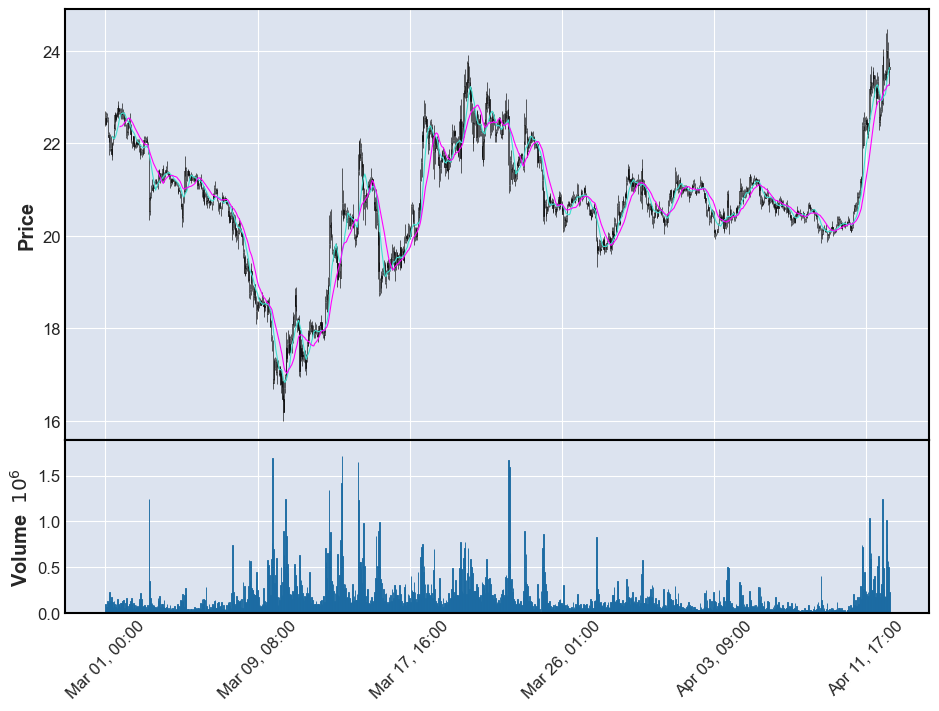

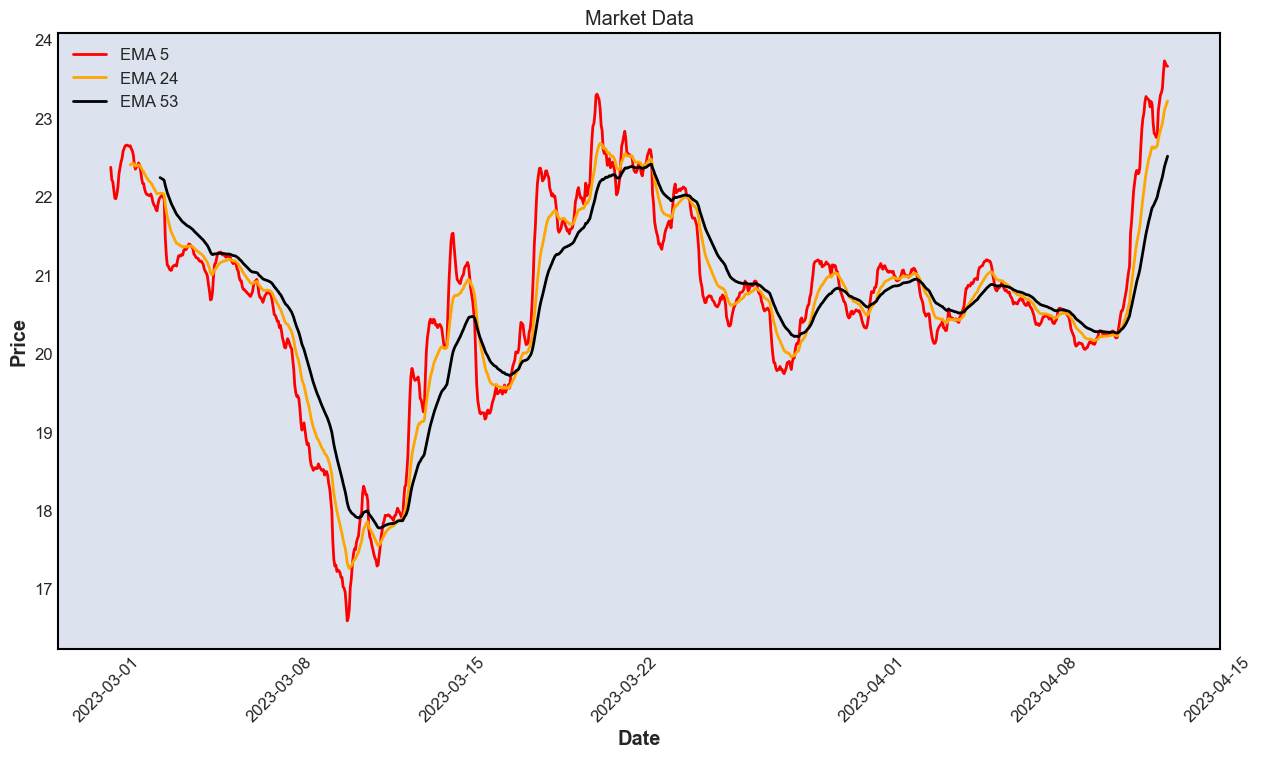

In [72]:
#plot the outcome

import pandas as pd
import matplotlib.pyplot as plt
# from mpl_finance import candlestick_ohlc
import mplfinance as mpf
import matplotlib.dates as mdates
from talib import EMA

# Load OHLCV data into a Pandas DataFrame
# df = pd.read_csv('ohlc_data.csv', parse_dates=True, index_col=0)
df = data

# Calculate exponential moving averages
df['EMA_5'] = EMA(df['close'], timeperiod=5)
df['EMA_24'] = EMA(df['close'], timeperiod=24)
df['EMA_53'] = EMA(df['close'], timeperiod=53)

# Prepare the data for plotting
# df_ohlc = df[['open', 'high', 'low', 'close']].resample('1D').ohlc()
# df_volume = df['volume'].resample('1D').sum()
# df_ohlc.reset_index(inplace=True)
# # df_ohlc['datetime'] = df_ohlc['datetime'].map(mdates.date2num)

# Create the plot
# fig, ax = plt.subplots()
# candlestick_ohlc(ax, df_ohlc.values, width=0.6, colorup='g', colordown='r', alpha=1.0)
mpf.plot(df,type='candle',volume=True,mav=(10,20),figscale=1.5,warn_too_much_data=2000)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.figure(figsize=(15,8))

plt.xticks(rotation=45)
plt.title('Market Data')
plt.ylabel('Price')
plt.xlabel('Date')

# Add EMA lines
plt.plot(df.index, df['EMA_5'], label='EMA 5', color='red')
plt.plot(df.index, df['EMA_24'], label='EMA 24', color='orange')
plt.plot(df.index, df['EMA_53'], label='EMA 53', color='black')

# Customize the plot
plt.legend()
plt.grid()
plt.show()
